In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from casadi import *
import GPy
from scipy.optimize import minimize

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import bayesoptlib as CBO

In [2]:

def f1(x):
    return (x-2)**4 + (x-2)**3 - 2*(x-2)**2 - 2*(x-2)

def f2(x):
    return 0.5*(x-0.5)**2

def f(x):
    return f1(x[0]) +  f2(x[1])
def consensus(x):
    return x[0] - x[1]
bnds = ((0, 4), (0, 4))
sol = minimize(f, (0,0), method='SLSQP',bounds = bnds,constraints= {"fun": consensus, "type": "eq"})
print(sol.x,sol.fun)

bounds1 = np.array([[0,4]])
bounds2 = np.array([[0,4]])

xmax = 4
rho = 2

def eval_augL1(x1):
    augL1 = f1(x1) #+ lam1*(x1-xavg) + rho/2*(x1-xavg)**2
    return np.array(augL1).reshape(-1,1)

def eval_augL2(x2):
    augL2 = f2(x2) #+ lam2*(x2-xavg) + rho/2*(x2-xavg)**2
    return np.array(augL2).reshape(-1,1)

[0.73522955 0.73522955] -0.10640218345601844


In [3]:
# setup ADMM 

lam1 = 0
lam2 = 0
x1opt = 2
x2opt = 1
xavg = (x1opt+x2opt)/2
res_primal1 = x1opt  - xavg
res_primal2 = x2opt  - xavg

# historical data
X1_sample = (np.array([x1opt])).reshape(1,1)
X2_sample = (np.array([x2opt])).reshape(1,1)
Y1_sample = eval_augL1(X1_sample) 
Y2_sample = eval_augL2(X2_sample)


inputDim = 1
kernel =  GPy.kern.RBF(inputDim,lengthscale = 0.68,variance=1234.62)
kernel2 =  GPy.kern.RBF(inputDim,lengthscale = 0.68,variance=2)

mf = GPy.core.Mapping(inputDim,1)
def prior_mean(x):
    y = 0*(x-2)**4 
    return y.reshape(-1,1)
mf.f = prior_mean
mf.update_gradients = lambda a,b: None

mf2 = GPy.core.Mapping(inputDim,1)
def prior_mean2(x):
    y = 0*(x-0.2)**2 
    return y.reshape(-1,1)
mf2.f = prior_mean2
mf2.update_gradients = lambda a,b: None

def augL(X,lam=lam1,xavg=xavg,rho = rho):
        return lam*(X-xavg) + rho/2*(X-xavg)**2

primal_residual = []
dual_residual = []

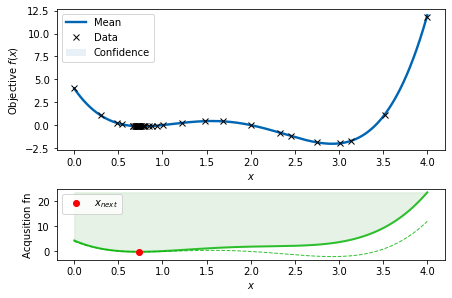

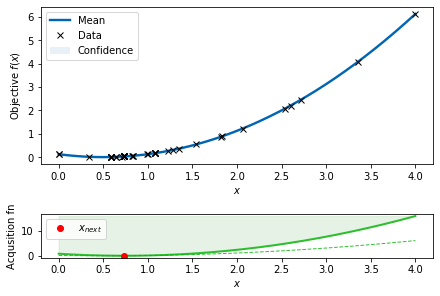

[0.73544211] [0.73787143]
[[-0.10582696]]


In [4]:

for k in range(0,50):
    #---------------------------------------------------------------------------------------------------

    context1 = np.array([lam1,xavg]).reshape(1,2)
    X1_grid = np.linspace(bounds1[:, 0].T, bounds1[:, 1].T, 1000).reshape(-1,1)
    CBO1 = CBO.bayesian_optimization(X1_sample,Y1_sample,
                                    bounds=bounds1,
                                    kernel = kernel,
                                    X_grid = X1_grid)
    CBO1.fit_gp()
    if k>20:
        CBO1.optimize_fit()
    CBO1.query_next('LCB',Aug=augL,args=(lam1,xavg,rho))
    X1_next = CBO1.X_next.reshape(-1,1)
    Y1_new = eval_augL1(X1_next) 
    X1_sample = np.vstack((X1_sample, X1_next))
    Y1_sample = np.vstack((Y1_sample, Y1_new))
    #---------------------------------------------------------------------------------------------------

    context2 = np.array([lam2,xavg]).reshape(1,2)
    X2_grid = np.linspace(bounds2[:, 0].T, bounds2[:, 1].T, 1000).reshape(-1,1)
    CBO2 = CBO.bayesian_optimization(X2_sample,Y2_sample,
                                    bounds=bounds2,
                                    kernel = kernel2,
                                    X_grid = X2_grid)
    CBO2.fit_gp()
    if k>20:
        CBO2.optimize_fit()
    CBO2.query_next('LCB',Aug=augL,args=(lam2,xavg,rho))
    X2_next = CBO2.X_next.reshape(-1,1)
    Y2_new = eval_augL2(X2_next)
    X2_sample = np.vstack((X2_sample, X2_next))
    Y2_sample = np.vstack((Y2_sample, Y2_new))
    #---------------------------------------------------------------------------------------------------

    xavg0 = xavg
    xavg = (X1_next + X2_next)/2
    lam1 = lam1 + rho*(X1_next - xavg)
    lam2 = lam2 + rho*(X2_next - xavg)

    primal_residual.append(np.asscalar(np.linalg.norm(X1_next - xavg) + np.linalg.norm(X2_next - xavg)))
    dual_residual.append(np.asscalar(rho**2*2*np.linalg.norm(xavg-xavg0)))

CBO1.plot()
CBO2.plot()
print(X1_next[:,0],X2_next[:,0])
print(Y1_new+Y2_new)


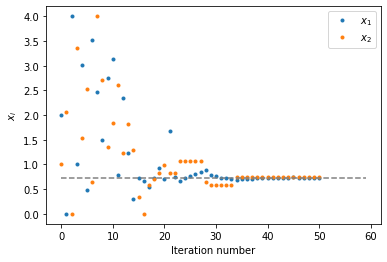

In [8]:

plt.plot(X1_sample[:,0],'.',label='$x_1$')
plt.plot(X2_sample[:,0],'.',label='$x_2$')
plt.xlabel('Iteration number')
plt.ylabel('$x_i$')
plt.legend()
plt.plot(np.array(range(0,60)).reshape(-1,1),0.73522955*np.ones((60,1)),'--',color=(0.5,0.5,0.5))
plt.savefig('consensus.pdf')
